<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Сохраняем-в-датафрейм-имеющийся-csv-файл." data-toc-modified-id="Сохраняем-в-датафрейм-имеющийся-csv-файл.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Сохраняем в датафрейм имеющийся csv-файл.</a></span></li><li><span><a href="#Изучим-общую-информацию-о-данных." data-toc-modified-id="Изучим-общую-информацию-о-данных.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Изучим общую информацию о данных.</a></span></li><li><span><a href="#Выводы." data-toc-modified-id="Выводы.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выводы.</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы." data-toc-modified-id="Выводы.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы.</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install mplcyberpunk -q
import mplcyberpunk
plt.style.use('cyberpunk')

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

In [4]:
# Функция для создания дополнительных параметров датасета.

def make_features(df, target_feature, max_lag, rolling_mean_size):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target_feature].shift(lag)

    data['rolling_mean'] = data[target_feature].shift().rolling(rolling_mean_size).mean()
    data['std'] = data[target_feature].rolling(rolling_mean_size).std()
    return data.dropna()

In [6]:
# Функция для обучения моделей, получения предсказаний и построения графика с реальными и спрогнозированными значениями.

def train_model(model, param_grid):
    random_search = RandomizedSearchCV(
        model, 
        param_grid, 
        cv=TimeSeriesSplit(),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE)
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_
    predictions = best_model.predict(X_train)
    rmse = abs(random_search.best_score_)
    return rmse, best_model

## Подготовка

### Сохраняем в датафрейм имеющийся csv-файл.

In [7]:
path = '/datasets/taxi.csv'

if os.path.exists(path):
    df_source = pd.read_csv(path, index_col=[0], parse_dates=[0])
else:
    print('File not found')

### Изучим общую информацию о данных.

In [8]:
# Cell - Run All Below

df = df_source.copy()

In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
# Отсортируем по дате, а также ресемплируем по 1 часу.

df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [12]:
print(df.index.min(), df.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00

Freq: H

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  4416 non-null   int64

dtypes: int64(1)

memory usage: 69.0 KB


In [14]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


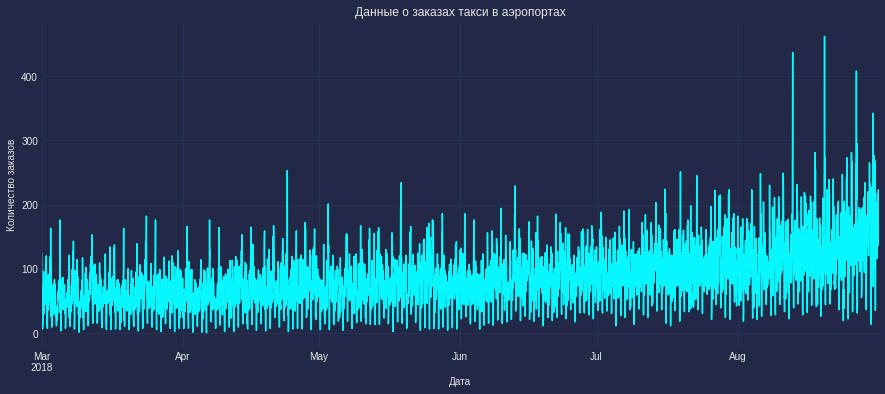

In [15]:
df.plot(figsize=(15,6), legend=False, title='Данные о заказах такси в аэропортах');
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

### Выводы.

- Предоставленные данные соответствуют описанию задачи.
- Пропуски не обнаружены.
- Типы данных соответствуют значениям.
- Представлены данные с 1 марта 2018 по 31 августа 2018, ресемплированы по одному часу.

## Анализ

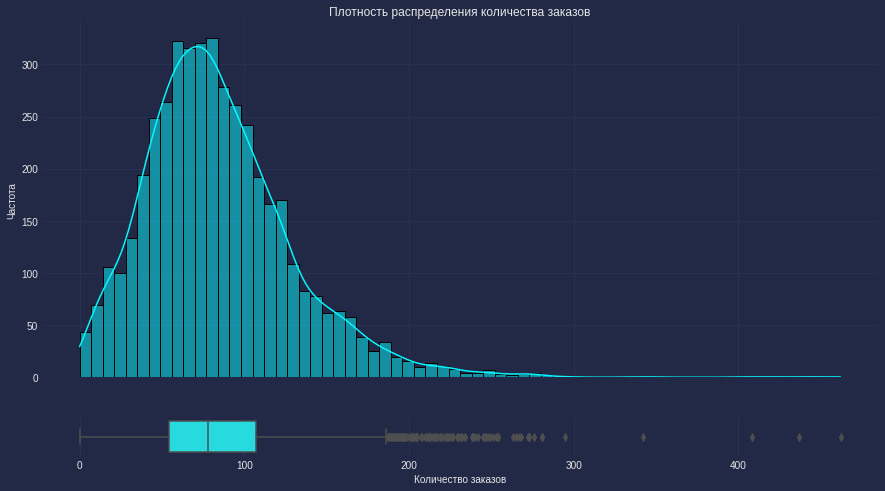

In [16]:
fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 8), sharex = True, gridspec_kw = {'height_ratios': (.9, .1)})
sns.boxplot(x = df['num_orders'], ax = ax_hist)
sns.histplot(data=df, x='num_orders', kde=True, ax = ax_box, bins=round(len(df['num_orders'])**0.5))
ax_box.set(ylabel = 'Частота', title = 'Плотность распределения количества заказов')
ax_hist.set(xlabel = 'Количество заказов')
plt.show()

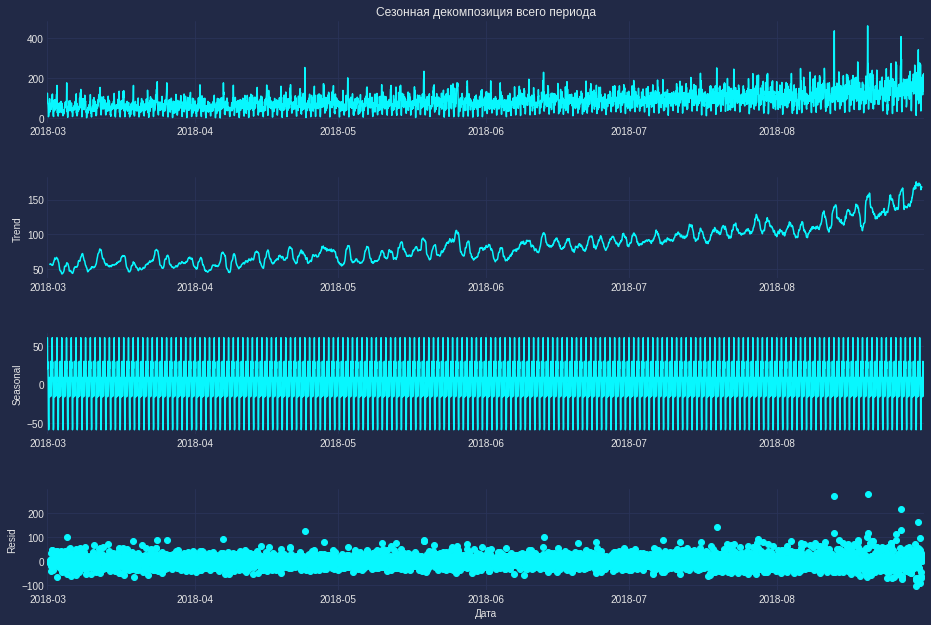

In [17]:
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
fig.set_size_inches((14,9))
plt.xlabel('Дата')
fig.axes[0].set_title('Сезонная декомпозиция всего периода')
plt.show()

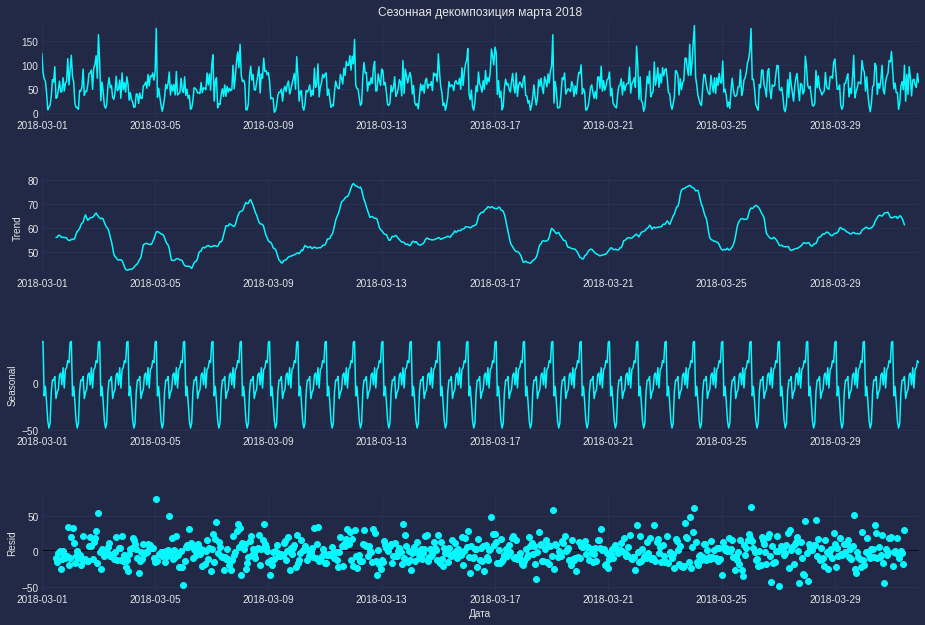

In [18]:
# Рассмотрим подробнее на 1м месяце март 2018

decomposition = seasonal_decompose(df['2018-03-01': '2018-03-31'])
fig = decomposition.plot()
fig.set_size_inches((14,9))
plt.xlabel('Дата')
fig.axes[0].set_title('Сезонная декомпозиция марта 2018')
plt.show()

In [19]:
ad_fuller_result = adfuller(df['num_orders'])
print(f'ADF Statistic:{ad_fuller_result[0]}')
print(f'p-value:{ad_fuller_result[1]}')

ADF Statistic:-3.0689242890279558

p-value:0.028940051402612906


In [20]:
df_roll = df.copy()
df_roll['rolling_mean'] = df_roll.shift().rolling(7).mean()

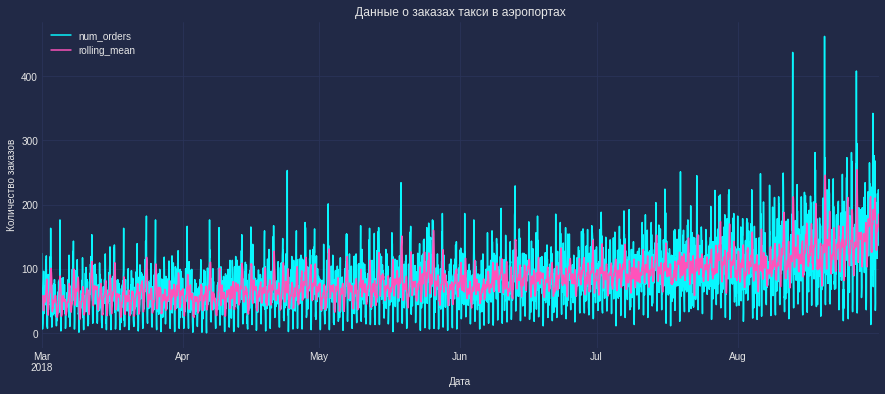

In [21]:
df_roll.plot(figsize=(15,6), title='Данные о заказах такси в аэропортах');
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Скользящее среднее со временем увеличивается, значит временной ряд не является стационарным. Нулевая гипотеза отвергается.

Промежуточные выводы:
- Количество заказов свыше 300 единиц в час имеет единичный характер, медианное значение - 78.
- Данные подготовлены, проанализированы, готовы для обучения.
- Имеется восходящий тренд на увеличение количества заказов.
- Пиковые значения в течение дня наблюдаются в околополуночные часы, а минимальные - ранним утром.
- Скользящее среднее со временем увеличивается, значит временной ряд не является стационарным.

## Обучение

In [22]:
# Добавим в датасет признаков

df_with_features = make_features(df, 'num_orders', 24, 100)

In [23]:
train, test = train_test_split(df_with_features, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

In [24]:
X_train = train.drop(['num_orders'], 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], 1)
y_test = test['num_orders']

### LinearRegression

In [25]:
rmse_LR, best_model_LR = train_model(LinearRegression(), [{'fit_intercept': [True, False]}, 
                                                          {'copy_X': [True, False]}, 
                                                          {'n_jobs': [1, -1]}])

### RandomForest

In [26]:
rmse_RF, best_model_RF = train_model(RandomForestRegressor(random_state=RANDOM_STATE), [{'n_estimators': range(50, 100, 10)}])

### CatBoost

In [27]:
rmse_catboost, best_model_catboost = train_model(CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=10),
                                                 [{'iterations': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}])

0:	learn: 29.0669237	total: 50.8ms	remaining: 2.49s

10:	learn: 27.8449831	total: 79.3ms	remaining: 281ms

20:	learn: 26.7340428	total: 107ms	remaining: 148ms

30:	learn: 25.7371906	total: 136ms	remaining: 83.2ms

40:	learn: 24.8143112	total: 164ms	remaining: 36ms

49:	learn: 24.0924259	total: 189ms	remaining: 0us

0:	learn: 30.5922831	total: 5.13ms	remaining: 251ms

10:	learn: 29.3421301	total: 38.6ms	remaining: 137ms

20:	learn: 28.2256562	total: 70.6ms	remaining: 97.5ms

30:	learn: 27.2108573	total: 102ms	remaining: 62.6ms

40:	learn: 26.3074006	total: 134ms	remaining: 29.4ms

49:	learn: 25.5626192	total: 162ms	remaining: 0us

0:	learn: 32.2658154	total: 4.83ms	remaining: 237ms

10:	learn: 30.8621010	total: 46.6ms	remaining: 165ms

20:	learn: 29.6529906	total: 83.6ms	remaining: 115ms

30:	learn: 28.5584499	total: 120ms	remaining: 73.4ms

40:	learn: 27.5757589	total: 158ms	remaining: 34.6ms

49:	learn: 26.7681877	total: 202ms	remaining: 0us

0:	learn: 33.1853656	total: 5.37ms	remaini

In [28]:
data_train = {
    "Модель": ['LinearRegression', 'RandomForest', 'CatBoost'],
    "RMSE на тренировочной выборке": [rmse_LR, rmse_RF, rmse_catboost],
}

data_train = pd.DataFrame(data_train)
data_train.sort_values(by='RMSE на тренировочной выборке')

,Модель,RMSE на тренировочной выборке
2,CatBoost,24.536493
1,RandomForest,25.074869
0,LinearRegression,27.099652


На тренировочной выборке хорошо показали себя результаты моделей RandomForest и CatBoost, RMSE 24.5 и 25.1 соответственно.

## Тестирование

In [29]:
predictions_test = best_model_RF.predict(X_test)
rmse_test = mean_squared_error(y_test, predictions_test, squared=False)
rmse_test

41.726321228291

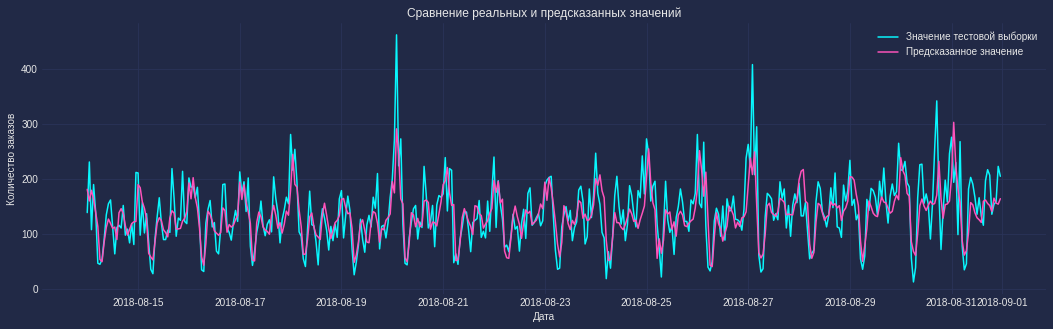

In [30]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(y_test, label = 'Значение тестовой выборки')
ax.plot(y_test.index, predictions_test, label = 'Предсказанное значение')
plt.legend()
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Судя по графику предсказанные значения не реагируют на реальные пиковые значения, но в целом учитывают суточные колебания. Учитывая наличие иных факторов, влияющих на количество заказов, таких как отпуска, предстоящая учеба в школах / ВУЗах, предсказанные результаты можно считать вполне неплохими, RMSE 41.7.

### Выводы.

- Представлены данные с 1 марта 2018 по 31 августа 2018, ресемплированы по одному часу.
- Количество заказов свыше 300 единиц в час имеет единичный характер, медианное значение - 78.
- Имеется восходящий тренд на увеличение количества заказов.
- Пиковые значения в течение дня наблюдаются в околополуночные часы, а минимальные - ранним утром.
- Временной ряд является стационарным.
- Для обучения использовались следующие модели: LinearRegression, RandomForestRegressor и CatBoost.
- Лучшее значение RMSE на тестовой выборке показала модель ~CatBoost 39.6~ RandomForestRegressor 41.7, соответственно, рекомендуем заказчику модель ~бустинга CatBoost~ RandomForestRegressor.